# This notebook was prepared by Omeh Chukwuemeka. [Github link](https://github.com/ChrisOmeh/End-to-end-Machine-Learning-on-Global-Power-Consumption)

# Kaggle Project Statement

* Often times, we always ask how do these National Electricity Distribution agencies measure and generate the bills the serve to their customers. Out of our inquisitive nature as man, we would realy like to know. It is not rocket science - because our bills are generated based on energy consumption in our household over a given period of time. So, how can i know what contribute to most energy consumption in my household? This is an important question that requires a holistic answer.

* Context: Measurements of electric power consumption in one household<b> with a one-minute sampling rate over a period of almost 4 years.</b> Different electrical quantities and some sub-metering values are available.

## Project Aim

* Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.


# DATA DESCRIPTION

### Data Set Characteristics:
Multivariate, Time-Series

### Associated Tasks:
Regression, Clustering

## Data Set Information:
Data Set Information:

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

Notes:

1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2. The dataset contains some missing values in the measurements (nearly 1.25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

[Source](http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)


### Attribute Information:
1. date: Date in format dd/mm/yyyy

2. time: time in format hh:mm:ss

3. globalactivepower: household global minute-averaged active power (in kilowatt)

4. globalreactivepower: household global minute-averaged reactive power (in kilowatt)

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9. submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

### DATA UNITS EXPLANATION
1. date and time: The date format is yyyy-mm-dd and time format is HH:MM:SS. The data point interval is reported every mins as average of all measurement taken within a min.
   
2. globalactivepower: This is measured in kilowatt i.e 1000watts. watts is unit of power and power energy expended per unit time.
   
3. global reactivepower: This is measured in kilowatt i.e 1000watts. watts is unit of power and power energy expended per unit time.
   
4. volt: Volt is unit of voltage - which tells the electric potential difference between two point in a conductor carrying current.

5. watt-hour: This measure of energy accross various appliances.

# Possible Project Objective
* I think you can do some time series forecasting with this dataset. For instance you could have fun trying to predict the active power consumption for the next N minutes given the consumption for the p former minutes. p is a hyper parameter of your model ( window width ).

[Source](https://www.kaggle.com/uciml/electric-power-consumption-data-set/discussion/126949)


In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [2]:
%cd "/content/gdrive/My Drive/STAGE_F_OPS_TIME_SERIES"

/content/gdrive/My Drive/STAGE_F_OPS_TIME_SERIES


In [3]:
!ls

household_power_consumption.txt


In [4]:
!pwd

/content/gdrive/My Drive/STAGE_F_OPS_TIME_SERIES


In [5]:
#Import processing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import os, warnings, gc
warnings.filterwarnings('ignore')
import scipy.stats as stats
import random
seed = 4092
random.seed(seed)
np.random.seed(seed)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

#Time series libraries
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import pacf, plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import  ARIMA
import statsmodels.api as sm

#Modelling libaries
import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from keras.callbacks import EarlyStopping

%matplotlib inline

In [6]:
#Setting display margins
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
plt.style.use('ggplot')
plt.rcParams['font.size'] = 10

In [7]:
#Loading dataset
"""
The parse_dates parametre have a value of dictionary pair where "datetime" 
is merging of date and time columns. The dictionary value in [0,1] means
column at index 0 and column at index 1 which are date and time respectively.
It can also be represented as ['Date', 'Time'] instead of [0,1].

The power generation measurement sensors started measurement at exactly 24mins pass 5pm on 
16th December 2006. The interval of measurement is every MINS
"""

df = pd.read_csv("household_power_consumption.txt", delimiter=';', parse_dates = {"datetime":[0,1]},
                 low_memory = False, infer_datetime_format=True)

df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00


In [8]:
df.tail()
#DURATION = 3 years, 11 months and 10 days

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075254,2010-11-26 20:58:00,0.946,0.000,240.430,4.000,0.000,0.000,0.00
2075255,2010-11-26 20:59:00,0.944,0.000,240.000,4.000,0.000,0.000,0.00
2075256,2010-11-26 21:00:00,0.938,0.000,239.820,3.800,0.000,0.000,0.00
2075257,2010-11-26 21:01:00,0.934,0.000,239.700,3.800,0.000,0.000,0.00
2075258,2010-11-26 21:02:00,0.932,0.000,239.550,3.800,0.000,0.000,0.00


In [9]:
print(f"The number of rows in the dataset is {df.shape[0]}")
print(f"The number of Columns in the dataset is {df.shape[1]}")

The number of rows in the dataset is 2075259
The number of Columns in the dataset is 8


In [10]:
#For easy analysis of our data, let create year, quater and month columns
df["datetime"]  = pd.to_datetime(df["datetime"])
df["Year"] = df["datetime"].apply(lambda X:X.year)
df["Quarter"] = df["datetime"].apply(lambda X:X.quarter)


In [11]:
df["Month"]  = df["datetime"].apply(lambda X:X.month)
df['Month_name'] = df["datetime"].apply(lambda X:X.month_name())
df["Year"].unique(),df["Quarter"].unique(),df["Month"].unique(), df['Month_name'].unique()

(array([2006, 2007, 2008, 2009, 2010]),
 array([4, 1, 2, 3]),
 array([12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array(['December', 'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November'], dtype=object))

In [12]:
df["dayofweek"] = df["datetime"].apply(lambda X:X.weekday())
df['dayofweek'].unique()

array([5, 6, 0, 1, 2, 3, 4])

In [13]:
df['day_name'] = df['datetime'].apply(lambda X:X.day_name())
df['day_name'].unique()

array(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday'], dtype=object)

In [14]:
df = df.set_index("datetime")
print(f"The number of rows and columns is now {df.shape[0]} and {df.shape[1]} respectively")
df.head()

The number of rows and columns is now 2075259 and 13 respectively


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Quarter,Month,Month_name,dayofweek,day_name
datetime,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.00,2006,4,12,December,5,Saturday
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.00,2006,4,12,December,5,Saturday
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.00,2006,4,12,December,5,Saturday
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.00,2006,4,12,December,5,Saturday
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.00,2006,4,12,December,5,Saturday


In [15]:
"""
1. The data info shows there are 8 object data type, 1 float type and 4 int 
   data type in initial data which is wrong from the result of data.head() method.

2. The DatetimeIndex have 20752559 entries and it starts from
   2006-12-16 17:24:00 to 2010-11-26 21:02:00
"""
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
 7   Year                   int64  
 8   Quarter                int64  
 9   Month                  int64  
 10  Month_name             object 
 11  dayofweek              int64  
 12  day_name               object 
dtypes: float64(1), int64(4), object(8)
memory usage: 221.7+ MB


In [16]:
#Checking for duplicate entries
print('Duplicate check shows there are some dupliacte entries', df[df.duplicated()].shape)

Duplicate check shows there are some dupliacte entries (56666, 13)


# Checking and Handling Missing Values
* In the whole data, it is only the Sub_metering_3 that have missing values with a total of 25979.
* The percentage of missing values in Sub_metering_3 columns is 1%. This means we can decide to drop 
  the missing values or fill with zero(s) or one(s) or using stastiscal variable.

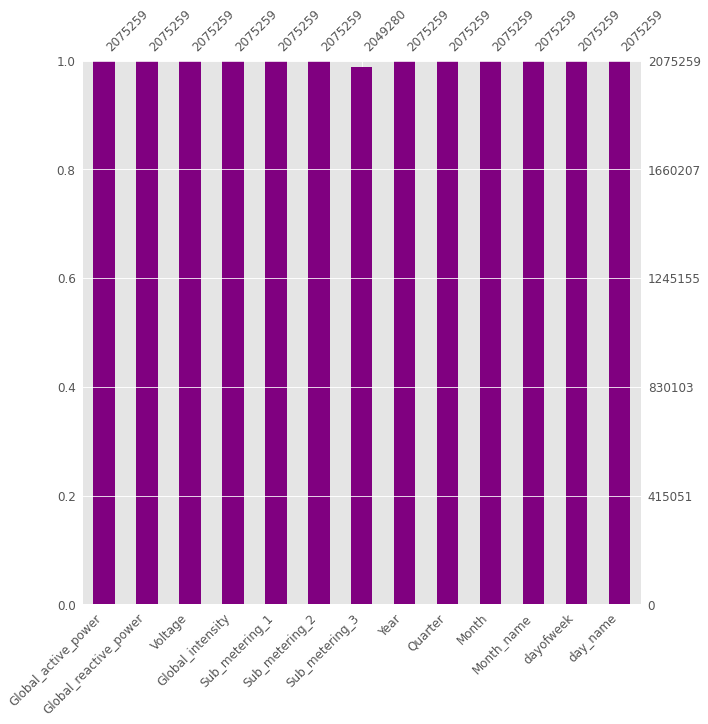

In [17]:
msno.bar(df, fontsize = 12, figsize = (10,10), color = 'purple');

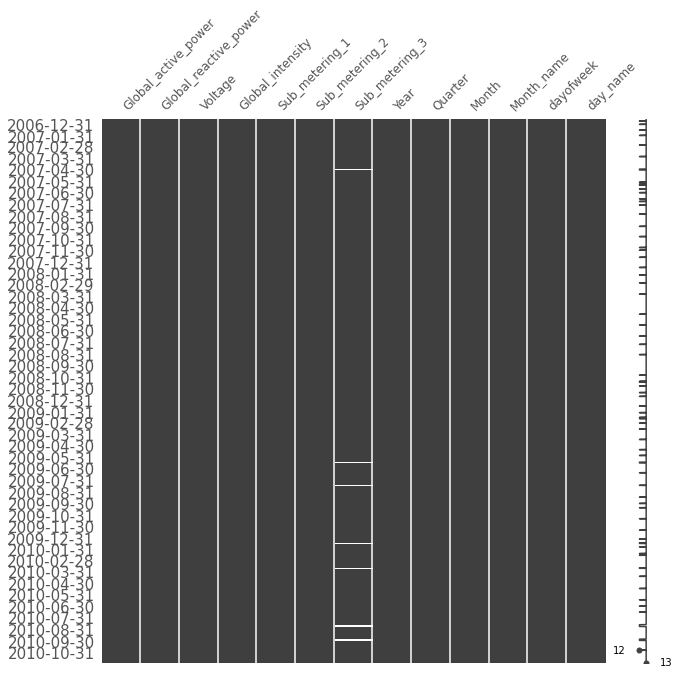

In [18]:
#Checking location and patterns of missing values
"""
The nullity matrix plot shows the that the following columns:
1. Global_active_power       
2. Global_reactive_power     
3. Voltage                   
4. Global_intensity         
5. Sub_metering_1      
6. Sub_metering_2 
don't have missing values except Sub_metering_3 column.
Majority of missing values in Sub_metering_3 column occur 
between the year 2007-04-30 and 2009-04-30

"""
msno.matrix(df, fontsize = 12, figsize = (10,10), freq = 'M');

In [19]:
#lenght of our data before and after we drop nan
len(df), len(df.dropna())

(2075259, 2049280)

In [20]:
#The total number of missing values are 25979.
len(df), sum(df.isnull().sum())

(2075259, 25979)

In [21]:
df.isnull().sum()

Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
Year                         0
Quarter                      0
Month                        0
Month_name                   0
dayofweek                    0
day_name                     0
dtype: int64

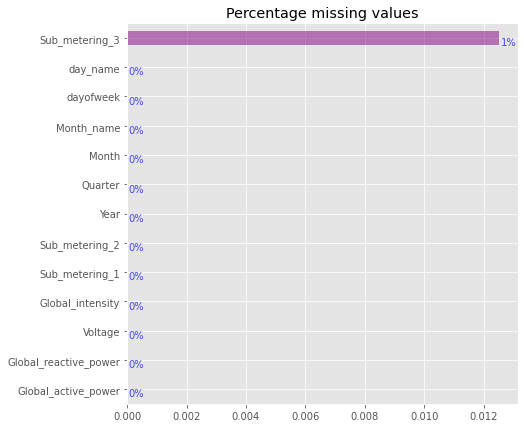

In [22]:
#Percentage of missing values
ax = df.isna().sum().transform(lambda x:x/df.shape[0]).sort_values().plot.barh(
     figsize=(7,7), title='Percentage missing values', color='purple', alpha=0.5)
for i in ax.patches:
    ax.text(i.get_width()+0.00005, i.get_y(), str(int(round(i.get_width(),2)*100))+'%', fontsize=10,
             color='b', alpha=0.7)

In [23]:
df.dtypes

Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
Year                       int64
Quarter                    int64
Month                      int64
Month_name                object
dayofweek                  int64
day_name                  object
dtype: object

In [24]:
df.describe(include = 'all')
#The describe shows a special character ?

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Quarter,Month,Month_name,dayofweek,day_name
count,2075259,2075259,2075259,2075259,2075259,2075259,2049280.00,2075259.00,2075259.00,2075259.00,2075259,2075259.00,2075259
unique,4187,533,2838,222,89,82,nan,nan,nan,nan,12,nan,7
top,?,0.000,?,1.000,0.000,0.000,nan,nan,nan,nan,August,nan,Thursday
freq,25979,481561,25979,172785,1880175,1436830,nan,nan,nan,nan,178560,nan,296640
mean,NaN,NaN,NaN,NaN,NaN,NaN,6.46,2008.44,2.49,6.45,NaN,3.00,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,8.44,1.13,1.11,3.42,NaN,2.00,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2006.00,1.00,1.00,NaN,0.00,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2007.00,1.00,3.00,NaN,1.00,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.00,2008.00,2.00,6.00,NaN,3.00,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,17.00,2009.00,3.00,9.00,NaN,5.00,NaN


In [25]:
#Replace ? with np.nan
df.replace('?', np.nan, inplace = True)

In [26]:
"""
Checking for missing values again shows that the special charater ? have 
added to missing values since it was replaced by np.nan

The are a total of 181853 missing values.
"""
df.isnull().sum()
print("There are {0} missing values in the whole dataset". format(sum(df.isna().sum())))

There are 181853 missing values in the whole dataset


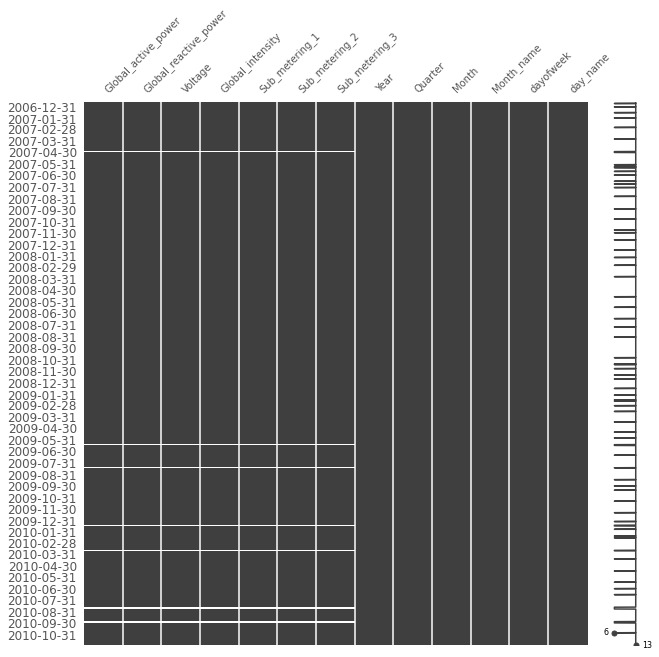

In [27]:
"""Let check the nullity matrix plot again to see the pattern of missing values.
The pattern as expected is same across the whole columns/features"""
df_nu = df.copy(deep = True)
df_nu.resample('D')
msno.matrix(df_nu, figsize = (10,10), fontsize = 10, freq = 'M');

In [28]:
# Covert all object data type to float64
for col in df.iloc[:, 0:-3]:
    if df[col].dtypes == 'object':
        df[col] = df[col].astype('float')
    else:
        pass
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Year                       int64
Quarter                    int64
Month                      int64
Month_name                object
dayofweek                  int64
day_name                  object
dtype: object

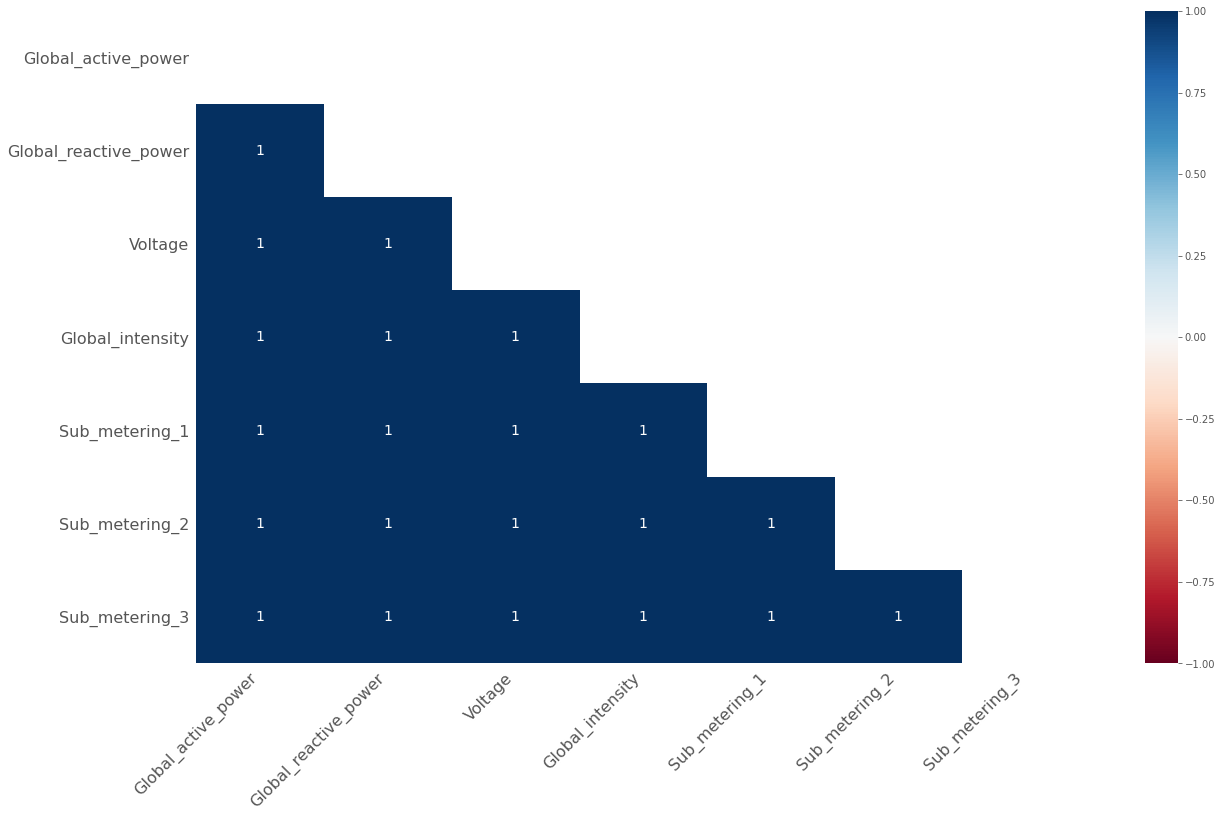

In [29]:
#Heatmap of missing values
msno.heatmap(df);

# Handling Missing Values

In [30]:
colums = ['Global_active_power', 'Global_reactive_power', 'Voltage',
          'Global_intensity','Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'] 
for cols in colums:
    print('==========',cols,'==========')
    df[cols].fillna(value = df[cols].mean(), inplace = True)
pass
df.isnull().sum()

========== Global_active_power ==========
========== Global_reactive_power ==========
========== Voltage ==========
========== Global_intensity ==========
========== Sub_metering_1 ==========
========== Sub_metering_2 ==========
========== Sub_metering_3 ==========


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Year                     0
Quarter                  0
Month                    0
Month_name               0
dayofweek                0
day_name                 0
dtype: int64

In [31]:
df.describe(include = 'all')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Year,Quarter,Month,Month_name,dayofweek,day_name
count,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259.00,2075259,2075259.00,2075259
unique,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12,nan,7
top,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,August,nan,Thursday
freq,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,178560,nan,296640
mean,1.09,0.12,240.84,4.63,1.12,1.30,6.46,2008.44,2.49,6.45,NaN,3.00,NaN
std,1.05,0.11,3.22,4.42,6.11,5.79,8.38,1.13,1.11,3.42,NaN,2.00,NaN
min,0.08,0.00,223.20,0.20,0.00,0.00,0.00,2006.00,1.00,1.00,NaN,0.00,NaN
25%,0.31,0.05,239.02,1.40,0.00,0.00,0.00,2007.00,1.00,3.00,NaN,1.00,NaN
50%,0.63,0.10,240.96,2.80,0.00,0.00,1.00,2008.00,2.00,6.00,NaN,3.00,NaN
75%,1.52,0.19,242.86,6.40,0.00,1.00,17.00,2009.00,3.00,9.00,NaN,5.00,NaN


# Visualizing Distribuction of the data

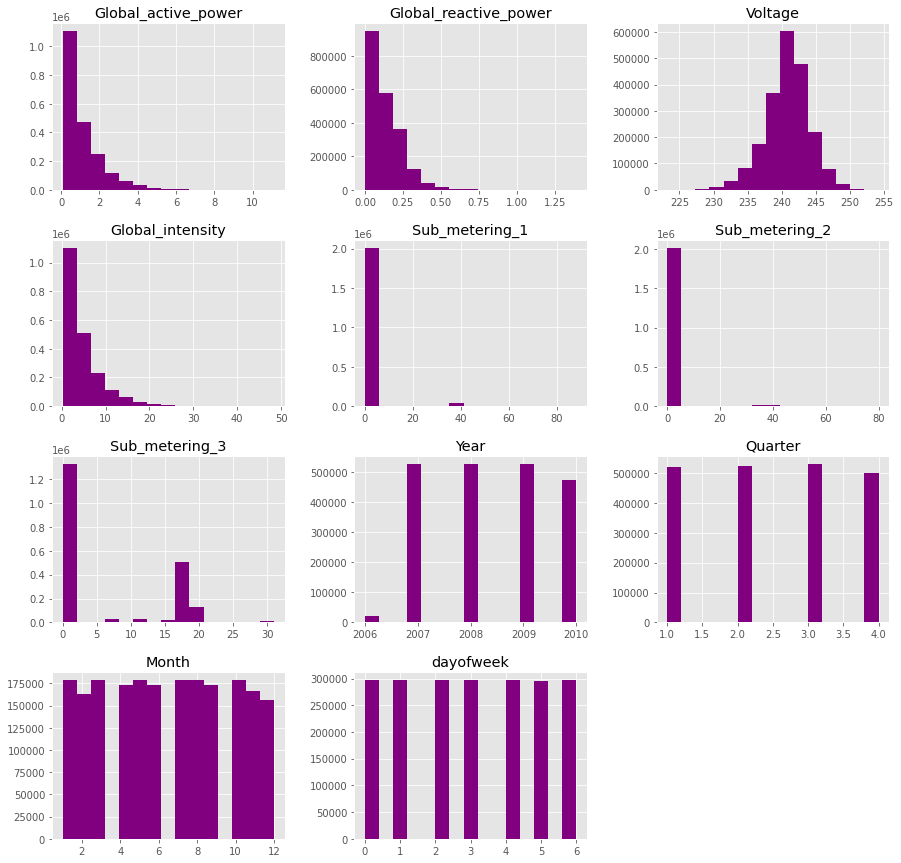

In [32]:
"""
Global_active_power, Global_reactive_power, Global Intensity and  are positively skewed, Voltage column
shows promising normal distribution of data and other columns are sparsely distributed.

The voltage data distribution shows the power voltage was fairly uniform across board.
"""
df.hist(column = df.columns, bins = 15, figsize = (15,15), color = 'purple', grid = True);
plt.show()

Text(0.5, 1.0, 'Distribution of Global Active power')

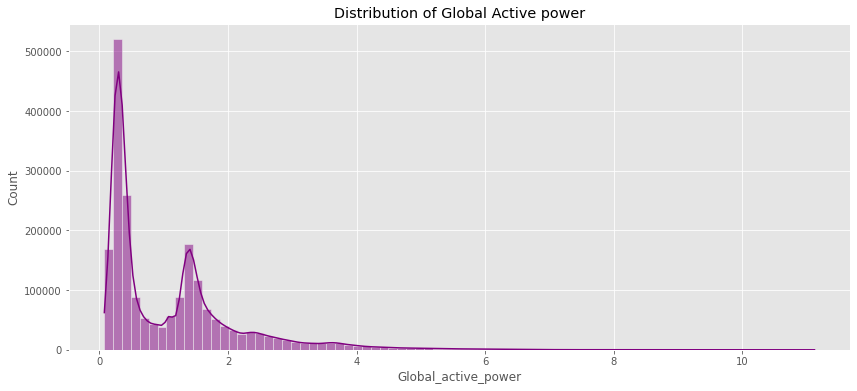

In [33]:
df1 = df.loc[:, ['Global_active_power']]
plt.figure(figsize=(14,6))
plt.subplot(1,1,1)
sns.histplot(df1['Global_active_power'], bins = 80, color= 'purple', kde= True);
plt.title('Distribution of Global Active power') 

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2075259.00,1.09,1.05,0.08,0.31,0.63,1.52,11.12


<Figure size 720x720 with 0 Axes>

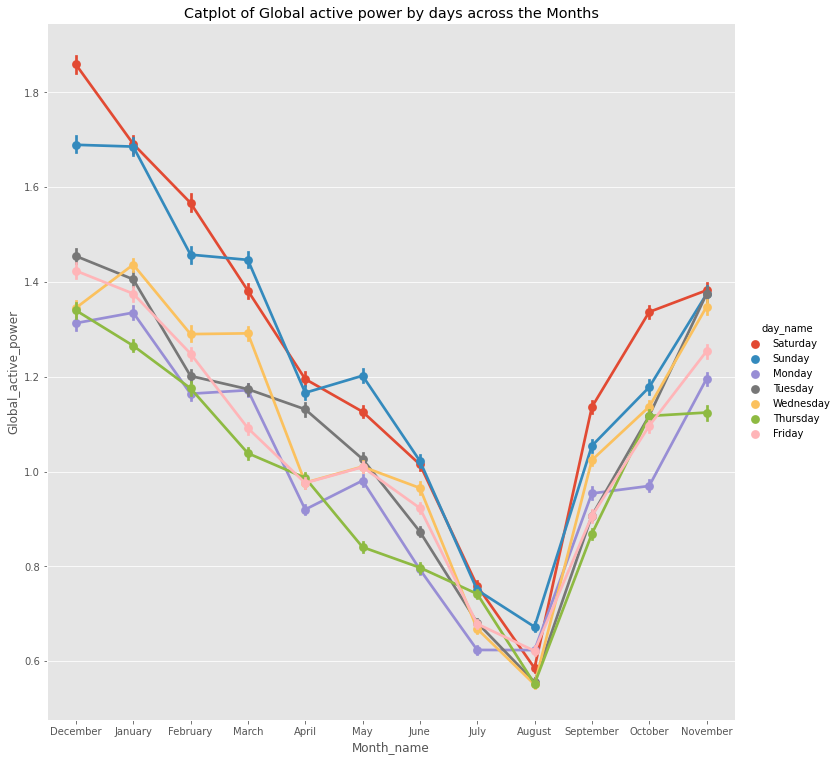

In [34]:
plt.figure(figsize=(10,10));
sns.catplot('Month_name','Global_active_power',hue='day_name',data=df, kind= 'point', height=10.2);                                                                                                                                                                                                                                                                                                                                            
plt.title('Catplot of Global active power by days across the Months');                                                                                                                                                               
df1.describe().T

Text(0.5, 1.0, 'Catplot of Global active power by days across the Years')

<Figure size 720x720 with 0 Axes>

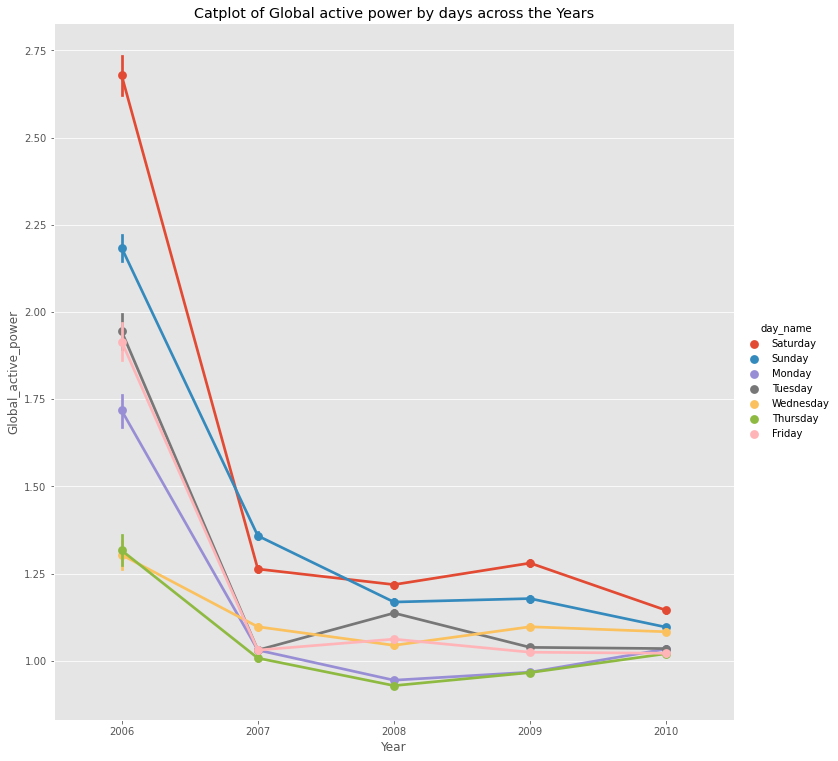

In [35]:
plt.figure(figsize=(10,10))
sns.catplot('Year','Global_active_power',hue='day_name',data=df, kind= 'point', height=10.2);                                                                                                                                                                                                                                                                                                                                            
plt.title('Catplot of Global active power by days across the Years') 

# Renaming Columns

In [36]:
#Renaming columns
cols = {'Global_active_power': 'Global_active_power(KW)',
        'Global_reactive_power':'Global_reactive_power(KW)',
        'Voltage': 'Voltage(V)',
        'Global_intensity': 'Global_intensity(Ampere)',
        'Sub_metering_1': 'Sub_metering_1(WH)',
        'Sub_metering_2': 'Sub_metering_2(WH)',
        'Sub_metering_3': 'Sub_metering_3(WH)'
       }
df.rename(cols, axis = 1, inplace = True)

# Feature Engineering

In [37]:
"""
1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) 
represents the active energy consumed every minute (in watt hour) in the household
by electrical equipment not measured in sub-meterings 1, 2 and 3.

1. Active_energy_consumed_per_min(WH) = ((globalactivepower*1000)/60)- Total_Submetering(WH)

2. Total_Submetering = submetering1+submetering2+submetering3

3. Cum_appliance_energy_consumption = Total_Submetering(WH) + Active_energy_consumed_per_min(WH)
"""

df['Total_Submetering(WH)'] = df['Sub_metering_1(WH)']+df['Sub_metering_2(WH)']+df['Sub_metering_3(WH)']
df['Active_energy_consumed_per_min(WH)'] = df['Global_active_power(KW)']*1000/60- df['Total_Submetering(WH)']
df["Cum_appliance_energy_consumption"] = df["Total_Submetering(WH)"] + df['Active_energy_consumed_per_min(WH)']
df.drop(columns = ['Sub_metering_1(WH)','Sub_metering_2(WH)','Sub_metering_3(WH)'], axis =1, inplace = True)
df.head()

,Global_active_power(KW),Global_reactive_power(KW),Voltage(V),Global_intensity(Ampere),Year,Quarter,Month,Month_name,dayofweek,day_name,Total_Submetering(WH),Active_energy_consumed_per_min(WH),Cum_appliance_energy_consumption
datetime,,,,,,,,,,,,,
2006-12-16 17:24:00,4.22,0.42,234.84,18.40,2006,4,12,December,5,Saturday,18.00,52.27,70.27
2006-12-16 17:25:00,5.36,0.44,233.63,23.00,2006,4,12,December,5,Saturday,17.00,72.33,89.33
2006-12-16 17:26:00,5.37,0.50,233.29,23.00,2006,4,12,December,5,Saturday,19.00,70.57,89.57
2006-12-16 17:27:00,5.39,0.50,233.74,23.00,2006,4,12,December,5,Saturday,18.00,71.80,89.80
2006-12-16 17:28:00,3.67,0.53,235.68,15.80,2006,4,12,December,5,Saturday,18.00,43.10,61.10


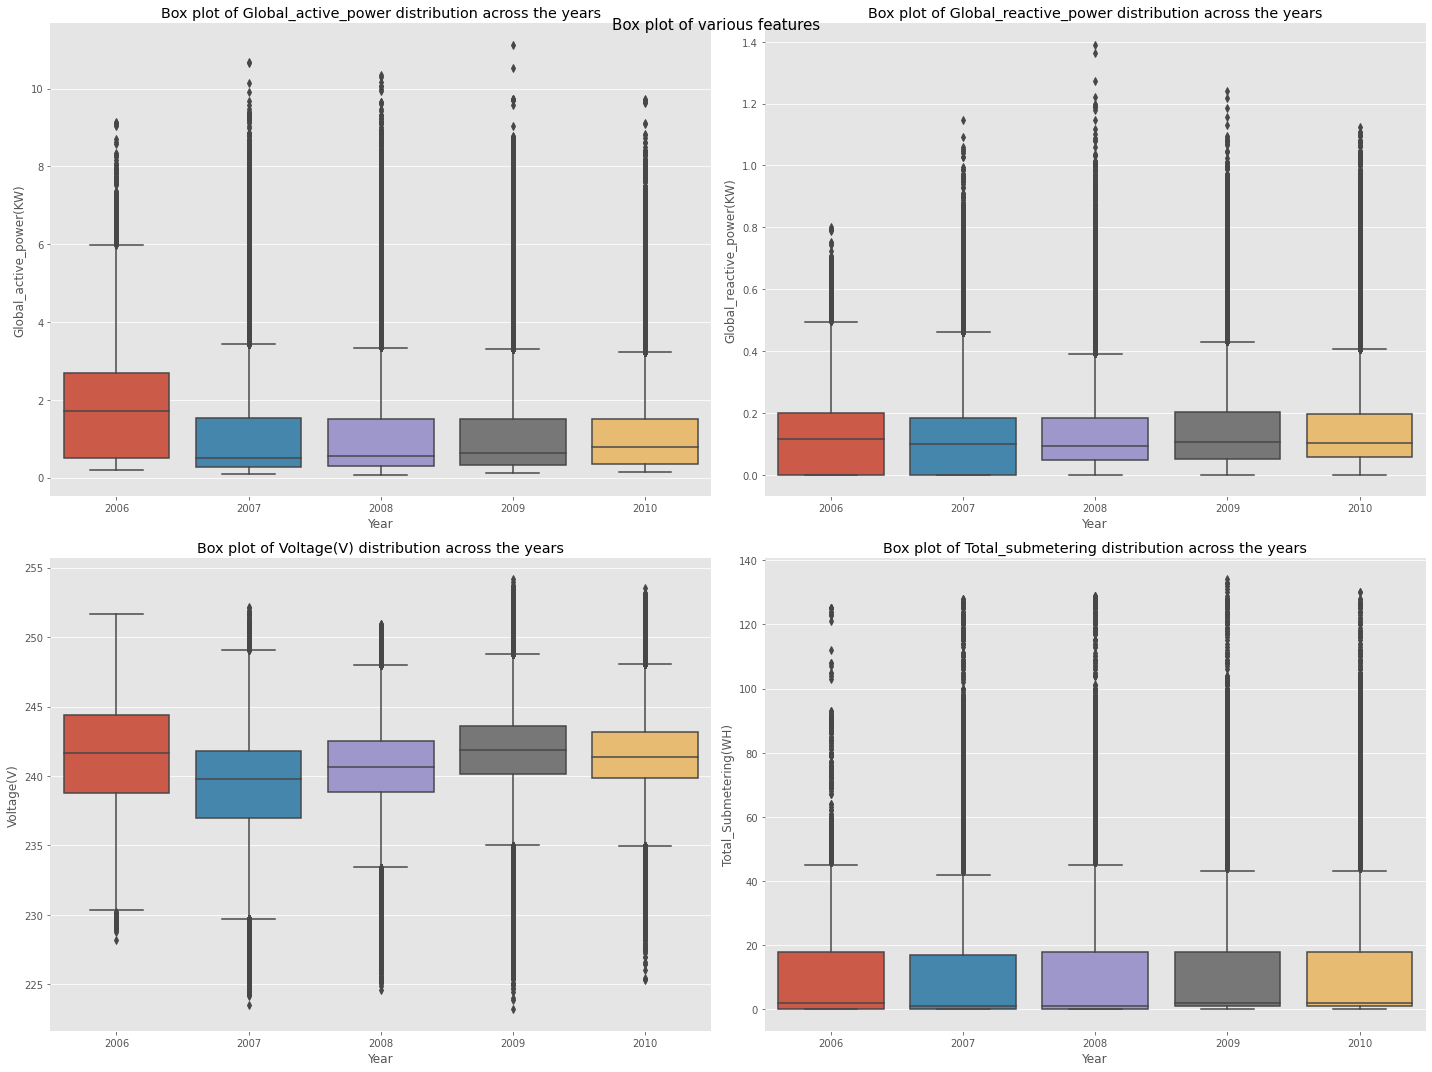

In [38]:
#Boxplots
plt.figure(figsize = (20,15))
plt.suptitle('Box plot of various features', fontsize = 15)
plt.subplots_adjust(wspace=0.3)
plt.grid(True)

plt.subplot(2,2,1)
sns.boxplot(data = df,x = 'Year', y = 'Global_active_power(KW)');
plt.title('Box plot of Global_active_power distribution across the years')
sns.despine(left= True)
plt.tight_layout()

plt.subplot(2,2,2)
sns.boxplot(data = df, x = 'Year', y = 'Global_reactive_power(KW)')
plt.title('Box plot of Global_reactive_power distribution across the years')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,3)
sns.boxplot(data=df, x = 'Year', y = 'Voltage(V)')
plt.title('Box plot of Voltage(V) distribution across the years')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,4)
sns.boxplot(data=df, x = 'Year', y = 'Total_Submetering(WH)')
plt.title('Box plot of Total_submetering distribution across the years')
sns.despine(left=True)
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

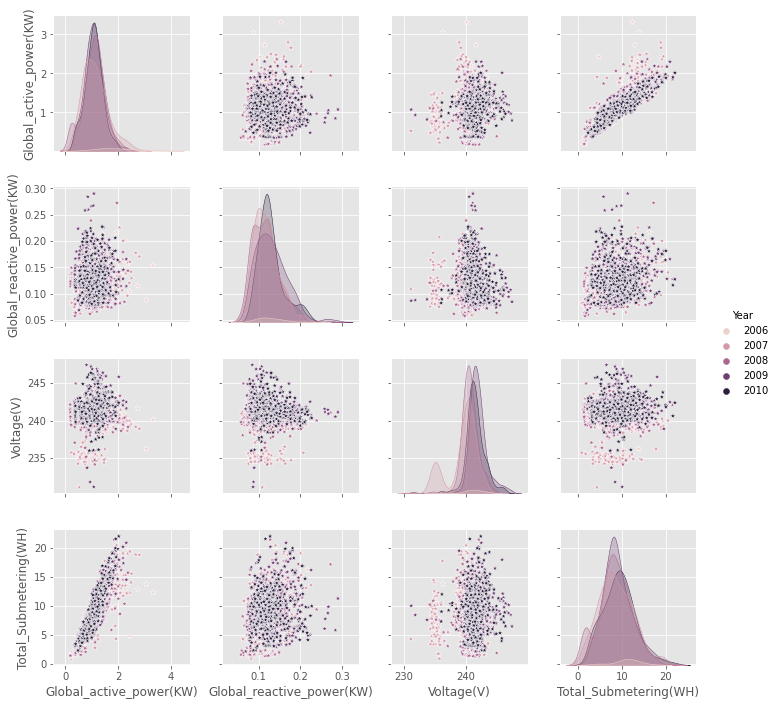

In [39]:
#Pairplot
df1 = df.loc[:, ['Global_active_power(KW)','Global_reactive_power(KW)','Voltage(V)', 'Total_Submetering(WH)', 'Year']].resample('D').mean()
df1 = df1.reset_index(drop=True)
plt.suptitle('pairplot of some features')
sns.pairplot(data = df1, hue='Year', markers='*');
plt.show()

# Time series Visualization

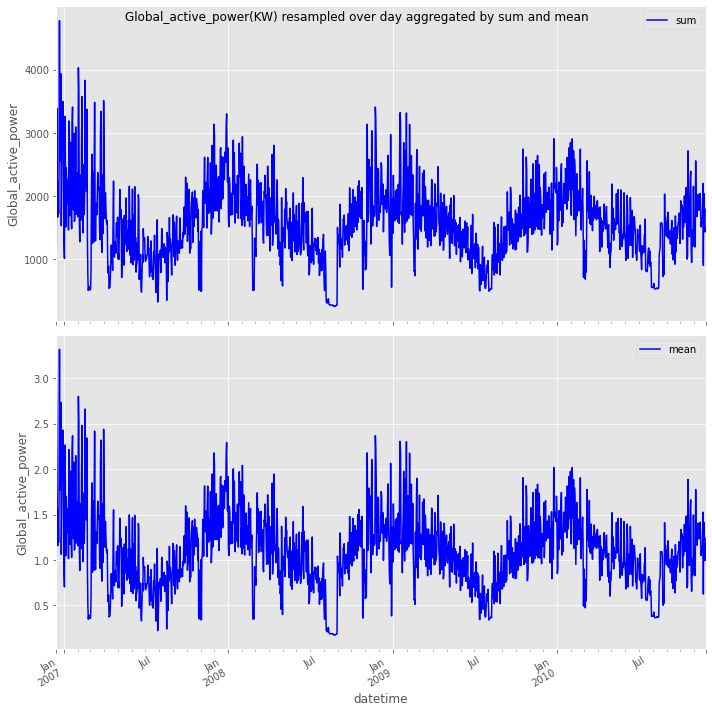

In [41]:
ga = df['Global_active_power(KW)'].resample('D').agg(['sum','mean'])
ga.plot(title = 'Global_active_power(KW) resampled over day aggregated by sum and mean',
        subplots = True, figsize = (10,10), ylabel = 'Global_active_power', color = 'blue');
plt.tight_layout()
plt.show()

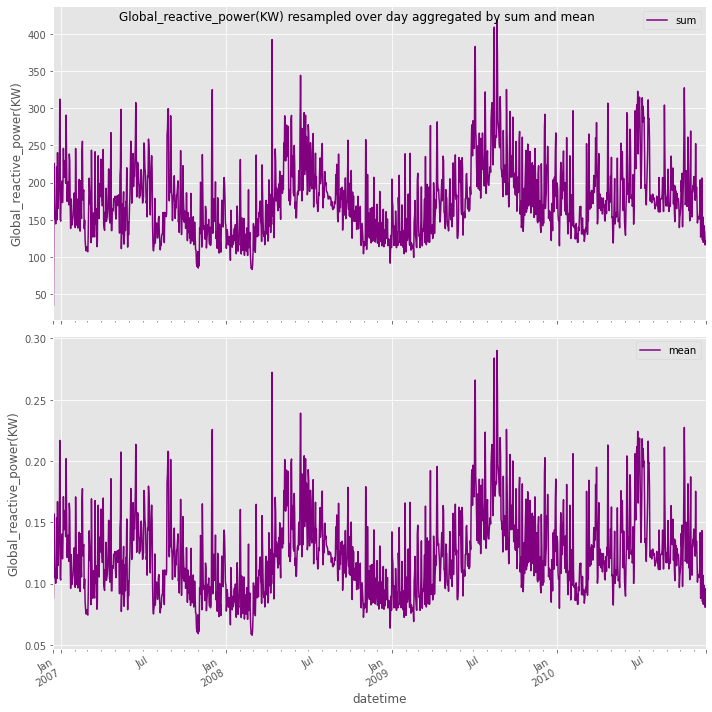

In [42]:
gr = df['Global_reactive_power(KW)'].resample('D').agg(['sum', 'mean'])
gr.plot(title = 'Global_reactive_power(KW) resampled over day aggregated by sum and mean',
       subplots = True, figsize = (10,10), ylabel = 'Global_reactive_power(KW)', color = 'purple')
plt.tight_layout()
plt.show()

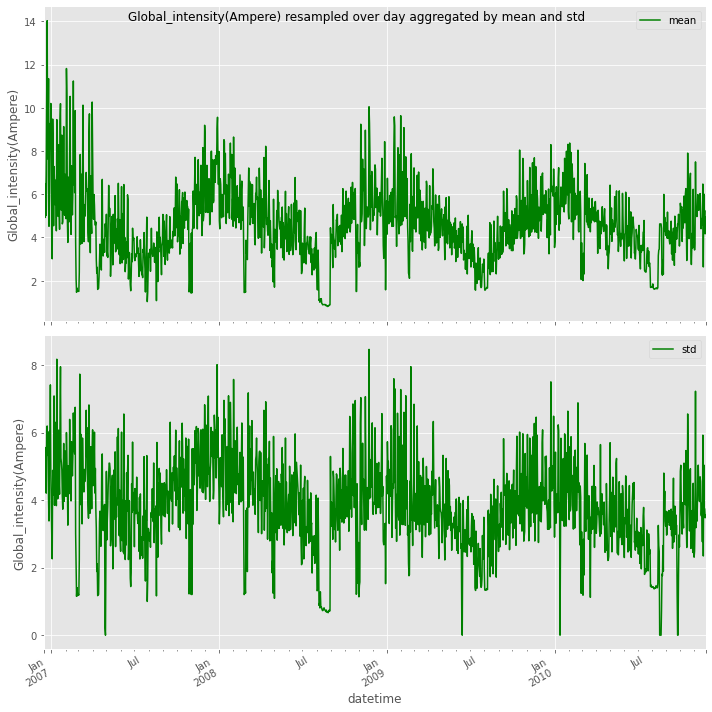

In [43]:
gi = df['Global_intensity(Ampere)'].resample('D').agg(['mean', 'std'])
gi.plot(title = 'Global_intensity(Ampere) resampled over day aggregated by mean and std',
       subplots = True, figsize = (10,10), ylabel = 'Global_intensity(Ampere)', color = 'green')
plt.tight_layout()
plt.show()

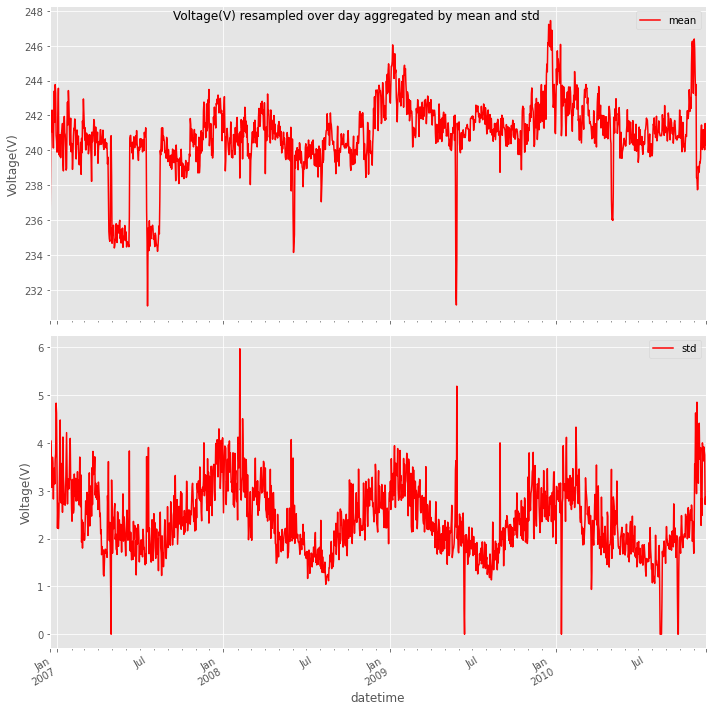

In [44]:
voltage = df['Voltage(V)'].resample('D').agg(['mean', 'std'])
voltage.plot(title = 'Voltage(V) resampled over day aggregated by mean and std',
       subplots = True, figsize = (10,10), ylabel = 'Voltage(V)', color = 'red')
plt.tight_layout()
plt.show()

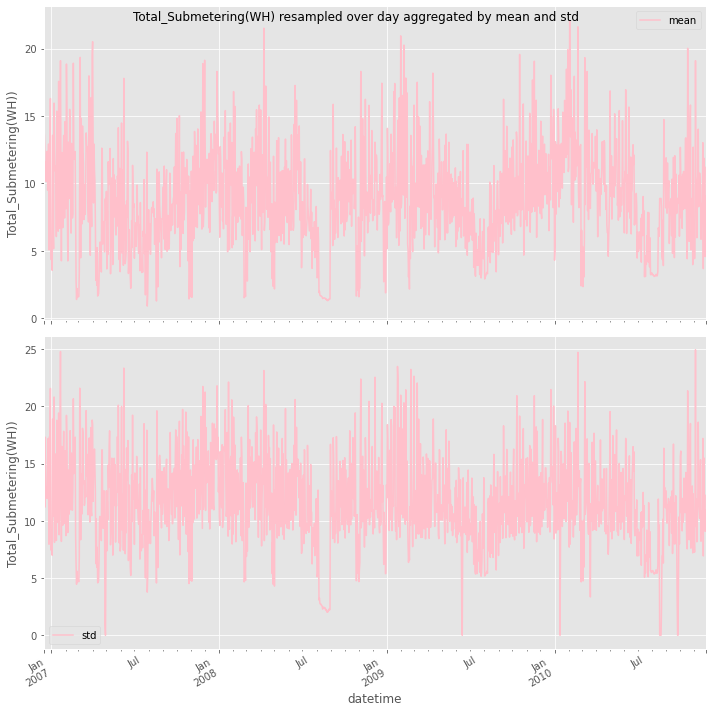

In [45]:
ts = df['Total_Submetering(WH)'].resample('D').agg(['mean', 'std'])
ts.plot(title = 'Total_Submetering(WH) resampled over day aggregated by mean and std',
       subplots = True, figsize = (10,10), ylabel = 'Total_Submetering(WH))', color = 'pink')
plt.tight_layout()
plt.show()

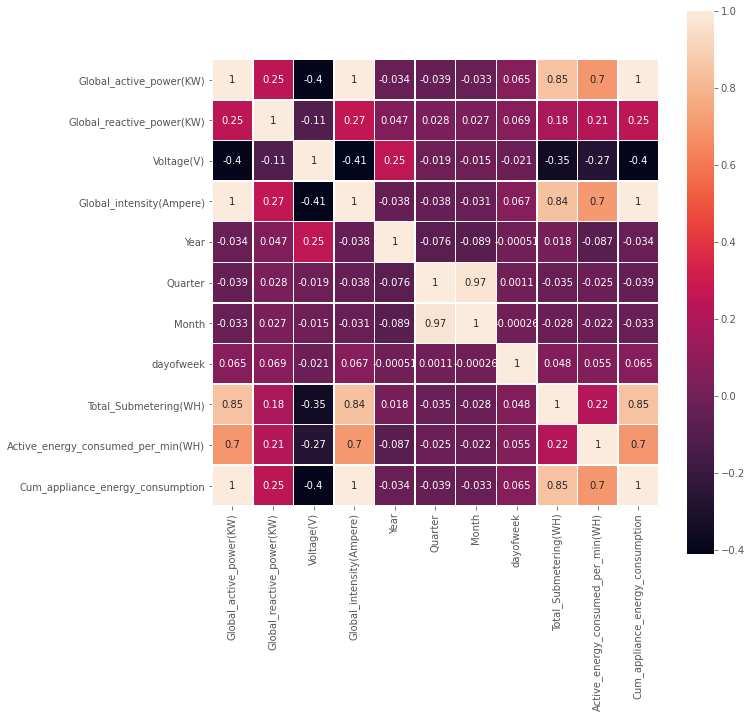

In [46]:
"""
The plot shows strong correlation between Global active power and Global intensity. 
Also, Total sub_metering is strongly correlated with global active power. It will be 
statistically advisable to drop the above mentioned two columns to solve problem 
of multicollinearity.
"""
df_corr = df.corr()
fig = plt.figure(figsize = (10,10))
sns.heatmap(df_corr, annot = True, linewidth = 0.5, square = True)
plt.show()

# Data Preparation for modeling

In [47]:
#let drop some columns
def drop_col(data):
    data.drop(columns = ['Global_reactive_power(KW)',"Global_intensity(Ampere)",
                         "Total_Submetering(WH)",'Year', 'Quarter', 'Month',], axis = 1, inplace = True)
    return data.columns
drop_col(df)

Index(['Global_active_power(KW)', 'Voltage(V)', 'Month_name', 'dayofweek',
       'day_name', 'Active_energy_consumed_per_min(WH)',
       'Cum_appliance_energy_consumption'],
      dtype='object')

# Time series stastistical check

In [48]:
#Using normaltest to check for stationarity
stat, p_value = stats.normaltest(df["Global_active_power(KW)"])
print('Statistics=%.3f, p=%.3f' % (stat, p_value))
alpha = 0.05 # significant difference values
if p_value > alpha:
    print('==Data looks Gaussian (fail to reject H0 meaning the timeseries is not stationary)==')
else:
    print('==Data does not look Gaussian (reject H0 meaning the timeseries is stationary)==')

Statistics=741661.563, p=0.000
==Data does not look Gaussian (reject H0 meaning the timeseries is stationary)==


In [49]:
"""
KEYNOTES
If The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher 
than any of the critical values. Clearly, there is no reason to reject the null hypothesis. 
So, the time series is in fact non-stationary.

Stationarity of time series dataset means a series whose statistical properties (e.g., mean, variance, autocorrelation) 
don’t change over time.

condition for stationarity
Null Hypothesis(H0) rejected meaning that there is no unit root and the time series is not time dependent
P>0.05 Fail to reject null hypothesis
p<= 0.05 Reject Null hypothesis and time series data is stationary

"""
#Stationarity check
df3 = df.resample('D').agg(np.mean)
def stationary_check(data_col):
    df3 = df.resample('D').agg(np.mean)
    original_timeseries = data_col
    rolling_mean = data_col.rolling(window = 30).mean()
    rolling_var =  data_col.rolling(window = 30).var()
    rolling_std =  data_col.rolling(window = 30).std()

    print("==========Plotting of rollings==========",'\n')
    plt.figure(figsize = (15,10))
    sns.despine(left = True)
    original_plot = plt.plot(original_timeseries, label = "Original Timeseries", color = 'purple', marker = 'o')
    rolling_mean_plot = plt.plot(rolling_mean, color = 'red', label = "rolling_mean", marker = 'x')
    rolling_var_plot = plt.plot(rolling_var,color = 'green', label = 'rolling variance', marker = '^')
    rolling_std_plot = plt.plot(rolling_std, label = "rolling_std", color = 'cyan',marker = '*' )
  
    plt.legend(loc='best'); plt.title('Rolling of Mean & Standard Deviation')
    plt.show()

    print('\n',"==========Augument Dickey Fuller Test==========")
    print("===The result show the TS is stationary because the ADF TEST STATISTICS value is lower than the Critical values===")
    adf_result = adfuller(original_timeseries.values, autolag = 'AIC')
    adf_output = pd.Series(adf_result[0:4], index= ['ADF Statistic','p-value','#Lags Used','Total used observations'])

    for key, value in adf_result[4].items():
      adf_output['Critical Value (%s)'%key] = value
    print(adf_output)


==========Plotting of rollings========== 



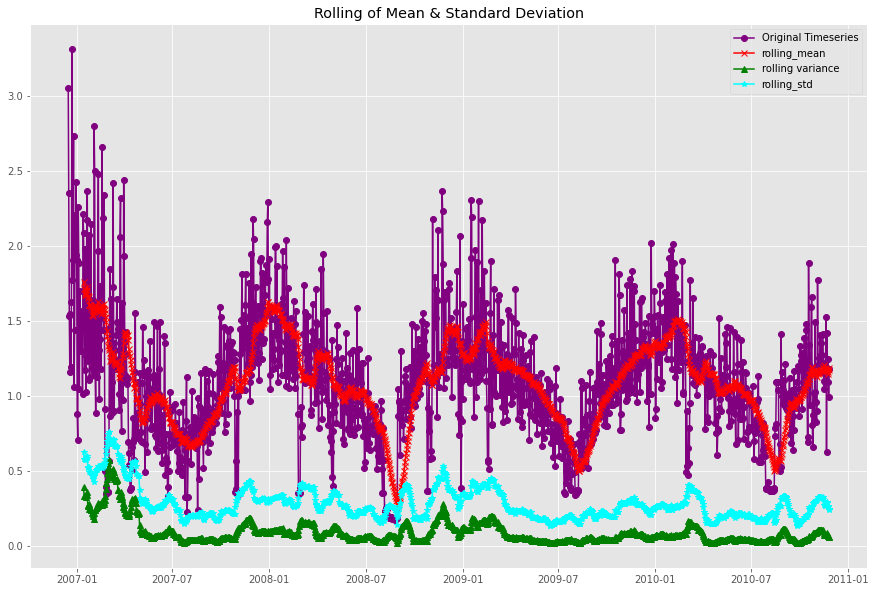


 ==========Augument Dickey Fuller Test==========
===The result show the TS is stationary because the ADF TEST STATISTICS value is lower than the Critical values===
ADF Statistic               -3.71
p-value                      0.00
#Lags Used                  22.00
Total used observations   1419.00
Critical Value (1%)         -3.43
Critical Value (5%)         -2.86
Critical Value (10%)        -2.57
dtype: float64


In [50]:
stationary_check(df3['Global_active_power(KW)'])

datetime
2006-12-16 17:24:00   nan
2006-12-16 17:25:00   nan
2006-12-16 17:26:00   nan
2006-12-16 17:27:00   nan
2006-12-16 17:28:00   nan
Name: Global_active_power(KW), dtype: float64
datetime
2006-12-16 17:24:00   -0.17
2006-12-16 17:25:00   -0.16
2006-12-16 17:26:00   -0.12
2006-12-16 17:27:00   -0.10
2006-12-16 17:28:00   -0.09
Name: Global_active_power(KW), dtype: float64
datetime
2006-12-16 17:24:00   nan
2006-12-16 17:25:00   nan
2006-12-16 17:26:00   nan
2006-12-16 17:27:00   nan
2006-12-16 17:28:00   nan
Name: Global_active_power(KW), dtype: float64
datetime
2006-12-16 17:24:00   4.22
2006-12-16 17:25:00   5.36
2006-12-16 17:26:00   5.37
2006-12-16 17:27:00   5.39
2006-12-16 17:28:00   3.67
Name: Global_active_power(KW), dtype: float64


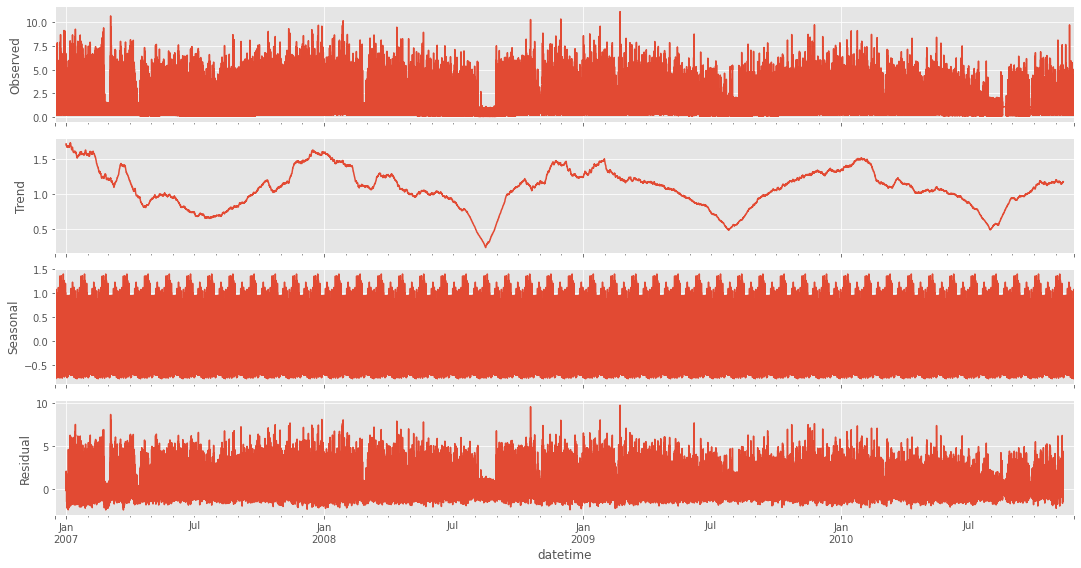

In [51]:
#To further check for stationarity, let check decompose the timeseries data.
#Our model type is additive and multiplicative
from pylab import rcParams
rcParams[ 'figure.figsize' ] = 15 , 8
timeseries_decompose_add = sm.tsa.seasonal_decompose(df["Global_active_power(KW)"],
                                                     model = 'additive', freq = (60*30*24))
print(timeseries_decompose_add.trend.head())
print(timeseries_decompose_add.seasonal.head())
print(timeseries_decompose_add.resid.head())
print(timeseries_decompose_add.observed.head())
timeseries_decompose_add.plot()
plt.show()

datetime
2006-12-16 17:24:00   nan
2006-12-16 17:25:00   nan
2006-12-16 17:26:00   nan
2006-12-16 17:27:00   nan
2006-12-16 17:28:00   nan
Name: Global_active_power(KW), dtype: float64
datetime
2006-12-16 17:24:00   0.81
2006-12-16 17:25:00   0.82
2006-12-16 17:26:00   0.88
2006-12-16 17:27:00   0.91
2006-12-16 17:28:00   0.91
Name: Global_active_power(KW), dtype: float64
datetime
2006-12-16 17:24:00   nan
2006-12-16 17:25:00   nan
2006-12-16 17:26:00   nan
2006-12-16 17:27:00   nan
2006-12-16 17:28:00   nan
Name: Global_active_power(KW), dtype: float64
datetime
2006-12-16 17:24:00   4.22
2006-12-16 17:25:00   5.36
2006-12-16 17:26:00   5.37
2006-12-16 17:27:00   5.39
2006-12-16 17:28:00   3.67
Name: Global_active_power(KW), dtype: float64


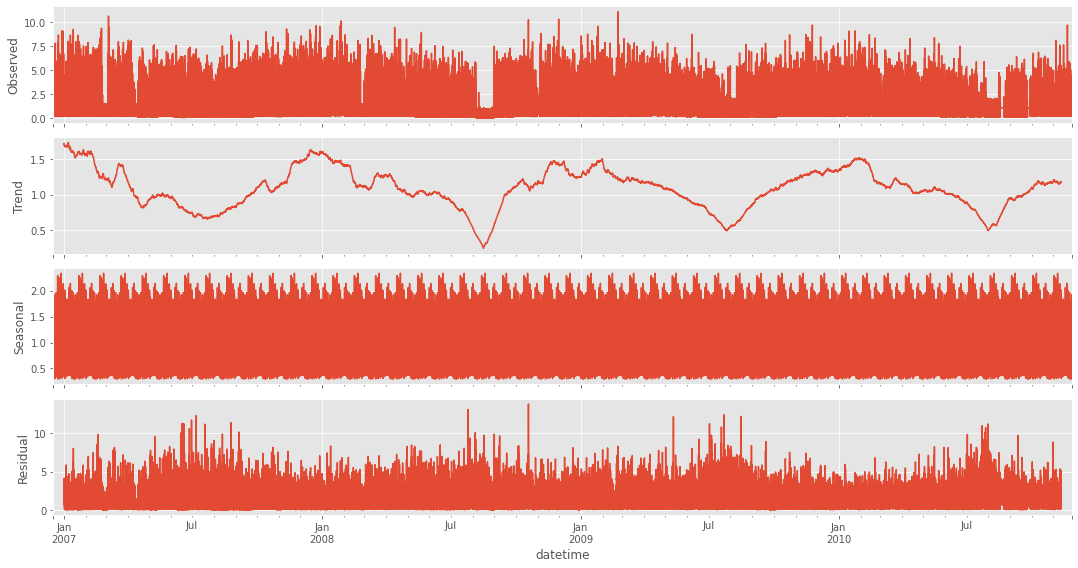

In [52]:
timeseries_decompose_mul = sm.tsa.seasonal_decompose(df["Global_active_power(KW)"],
                                                     model = 'multiplicative', freq = (60*30*24))
print(timeseries_decompose_mul.trend.head())
print(timeseries_decompose_mul.seasonal.head())
print(timeseries_decompose_mul.resid.head())
print(timeseries_decompose_mul.observed.head())
timeseries_decompose_mul.plot()
plt.show()

# Data Modeling

## Using ARIMA Model

* ARIMA stands for Autoregressive Integrated Moving Average.
* It depends on 3 important parametres
1. Number Autoregression(AR) term paramentre(p)
2. Number of Moving Average(MA) term(q)
3. Number of Difference(d, usually 0 or 1)

### Determing p and q
* To determine these terms, we are going to use Autocorrelation Function(ACF) and Passive Auto Correlation Function(PACF) plots.


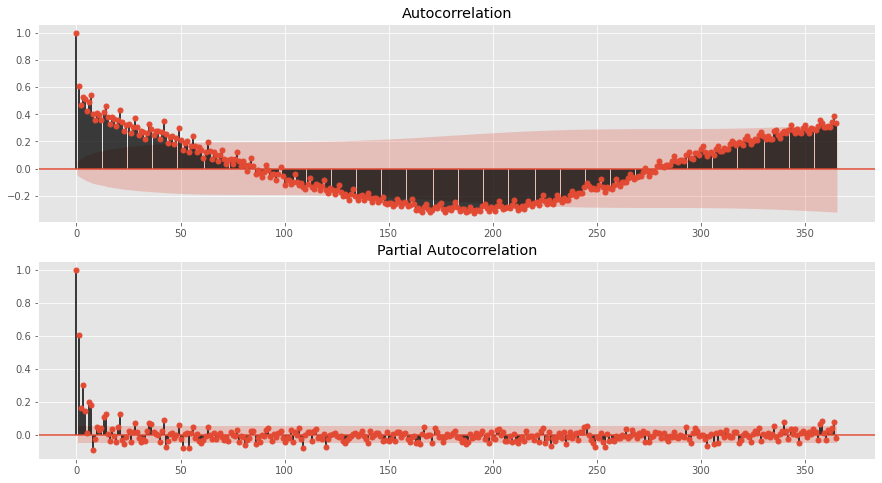

In [53]:
#ACF AND PACF PLOT Shows our p = 7 and q = 1
# plots
plt.figure()
lags = 365
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(df3['Global_active_power(KW)'], ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(df3['Global_active_power(KW)'], ax=axis, lags=lags, method='ols')
# show plot
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


                                      ARIMA Model Results                                       
Dep. Variable:     D.Active_energy_consumed_per_min(WH)   No. Observations:              2075258
Model:                                   ARIMA(7, 1, 0)   Log Likelihood            -5113729.775
Method:                                         css-mle   S.D. of innovations              2.844
Date:                                  Tue, 27 Oct 2020   AIC                       10227477.550
Time:                                          21:20:58   BIC                       10227590.460
Sample:                                      12-16-2006   HQIC                      10227507.741
                                           - 11-26-2010                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
co

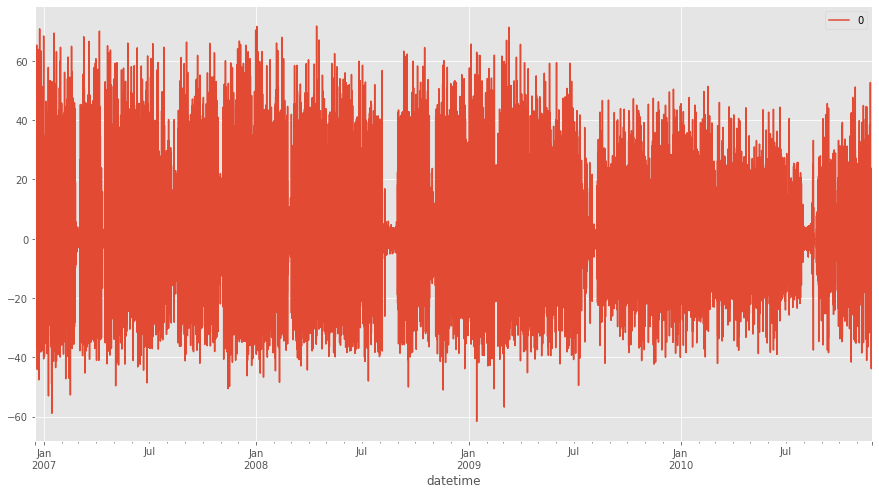

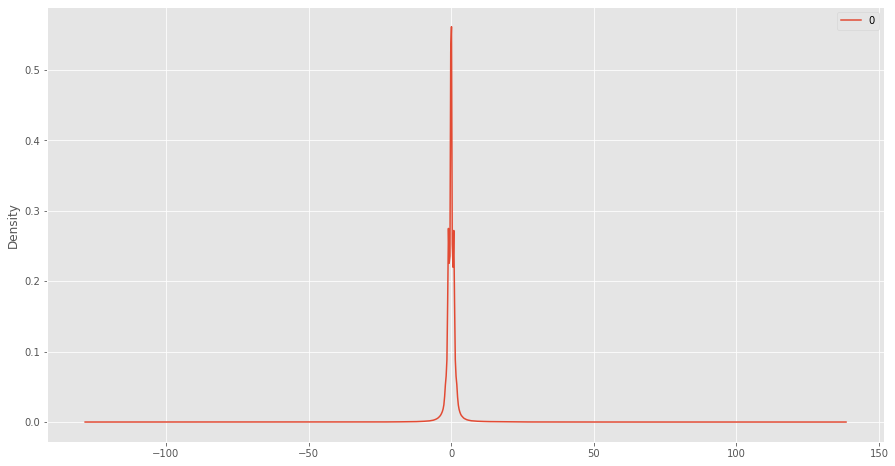

               0
count 2075258.00
mean        0.00
std         2.84
min       -61.66
25%        -0.78
50%        -0.01
75%         0.71
max        71.75


In [55]:
# fit model
model = ARIMA(df['Active_energy_consumed_per_min(WH)'], order=(7,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

# Data Preprocessing

In [56]:
# Data Preprocessing
"""
Since we are using a Recurrent Neural network, it is better to use MinMaxScaler
"""
data = df['Global_active_power(KW)'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(data) # The fit_transform method converts the data to numpy array stored in dataset variable
print("The type of dataset is {}". format(type(dataset)))
print("==dataset:",'\n',dataset[:5],"==")


The type of dataset is <class 'numpy.ndarray'>
==dataset: 
 [[0.37479631]
 [0.47836321]
 [0.47963064]
 [0.48089806]
 [0.32500453]] ==


In [57]:
# Creating Training and Testing Dataset
train_size = int(len(dataset)*0.8)
test_size = int(len(dataset)*0.2)

train, test = dataset[:train_size,:], dataset[train_size:len(dataset),:]


#Convert an array of values into a dataset matrix
def create_dataset(dataset, n_class = 1):
    X, Y = [], []
    for i in range(len(dataset)-n_class-1):
        a = dataset[i:(i+n_class), 0]
        X.append(a)
        Y.append(dataset[i + n_class, 0])
    return np.array(X), np.array(Y)
    
X_train, y_train = create_dataset(train, 30)
X_test, y_test = create_dataset(test,30)

# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1660176, 1, 30), (415021, 1, 30), (1660176,), (415021,))

## Using LSTM
### Model Archtecture
* One dense layer
* Used Dropout regularization with dropout of 0.2

In [59]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

Epoch 1/20
23717/23717 [==============================] - 79s 3ms/step - loss: 7.5490e-04 - val_loss: 3.7701e-04
Epoch 2/20
23717/23717 [==============================] - 78s 3ms/step - loss: 6.5950e-04 - val_loss: 3.7296e-04
Epoch 3/20
23717/23717 [==============================] - 78s 3ms/step - loss: 6.4734e-04 - val_loss: 3.7082e-04
Epoch 4/20
23717/23717 [==============================] - 80s 3ms/step - loss: 6.4183e-04 - val_loss: 3.6979e-04
Epoch 5/20
23717/23717 [==============================] - 81s 3ms/step - loss: 6.3705e-04 - val_loss: 3.6978e-04
Epoch 6/20
23717/23717 [==============================] - 80s 3ms/step - loss: 6.3309e-04 - val_loss: 3.6946e-04
Epoch 7/20
23717/23717 [==============================] - 80s 3ms/step - loss: 6.2900e-04 - val_loss: 3.6969e-04
Epoch 8/20
23717/23717 [==============================] - 80s 3ms/step - loss: 6.2721e-04 - val_loss: 3.7156e-04
Epoch 9/20
23717/23717 [==============================] - 80s 3ms/step - loss: 6.2534e-04 - val_

# Making Prediction

In [61]:
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

#Since we transformed our training and test data, we need to inverse it to get the real predicted values
train_prediction = scaler.inverse_transform(train_prediction)
y_train = scaler.inverse_transform([y_train])

test_prediction = scaler.inverse_transform(test_prediction)
y_test = scaler.inverse_transform([y_test])


# Evaluation Metrics

In [70]:
#Mean Square Error and RMSE
print(f"The Train Mean Suared Error is {round(mean_squared_error(y_train[0], train_prediction[:,0]),3)}")
print(f"The Train Root Mean Suared Error is {round(np.sqrt(mean_squared_error(y_train[0], train_prediction[:,0])),3)}")

print(f"The Test Mean Suared Error is {round(mean_squared_error(y_test[0], test_prediction[:,0]),3)}")
print(f"The Test Root Mean Suared Error is {round(np.sqrt(mean_squared_error(y_test[0], test_prediction[:,0])),3)}")


The Train Mean Suared Error is 0.071
The Train Root Mean Suared Error is 0.266
The Test Mean Suared Error is 0.045
The Test Root Mean Suared Error is 0.212


# Loss Plots

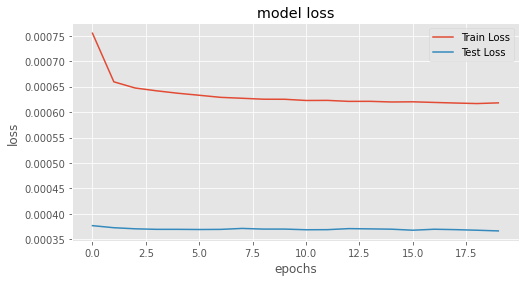

In [67]:
#Plot Model Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='best')
plt.show();

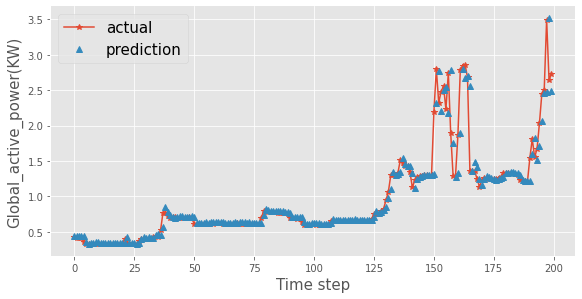

In [69]:
#comparing the actual and predictions for the last 200 minutes
data_list = [x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(data_list, y_test[0][:200], marker='*', label="actual")
plt.plot(data_list, test_prediction[:,0][:200], '^', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power(KW)', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

# The End